<a href="https://colab.research.google.com/github/ydchen17/SeizureDetection/blob/main/FFT%2BSVM%26MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import numpy as np
import math
import scipy as sp
from scipy import signal
from scipy import fftpack
from scipy.integrate import simps
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import butter, filtfilt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# load data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7445k  100 7445k    0     0  26.6M      0 --:--:-- --:--:-- --:--:-- 26.5M
CSV data is cleansed


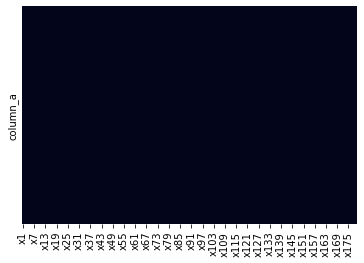

In [117]:
!curl -O https://raw.githubusercontent.com/ydchen17/datasets/main/uci-epileptic-seizure-recognition.csv
epilepsyDF = pd.read_csv('uci-epileptic-seizure-recognition.csv', index_col=0)


# shuffle the original data rows from the csv file
# epilepsyDF = epilepsyDF.sample(frac=1)


# Check for missing values, nulls, NaNs as part of initial pre processing work. Very important !
an = epilepsyDF.isnull().sum()

# print(an)
# X = epilepsyDF.iloc[:,1:179].values
# epilepsyDF.info()
# epilepsyDF.describe()

dataLoadingDF = epilepsyDF.copy(deep = True)

# print(epilepsyDF)
# print(dataLoadingDF)

column_names = ["YLabel", "Max", "Min", "Mean", "SD", "Variance", "RMS", "ZeroXings", "TPeaks", 
                "TMax1", "TMax2", "TMax3", "FPeaks", "FMax1", "FMax2", "FMax3", "PSD", 
                "RelativeAlpha", "RelativeBeta", "RelativeTheta", "RelativeDelta"]
MyDF = pd.DataFrame(columns = column_names)
# print(MyDF)

# print(epilepsyDF.shape)
# print(epilepsyDF.dtypes)
# print(epilepsyDF.index)

# print(type(epilepsyDF.index))
# print(type(epilepsyDF.columns))
# print(type(epilepsyDF.values))

# print(epilepsyDF['y'])
# print(epilepsyDF[['X1', 'y']])
# print(type1_DF.iloc[:5, 0:2])


### Remove the y classification label column because these dataframes are used for actual calculations.
### y label column not required

# Type 1 Epilepsy ######
type1 = epilepsyDF['y'] == 1
type1_DF = epilepsyDF[type1]
type1_DF = type1_DF.drop(labels='y', axis=1) 
# print(type1_DF)
# ######################

# Type 2 Epilepsy ######
type2 = epilepsyDF['y'] == 2
type2_DF = epilepsyDF[type2]
type2_DF = type2_DF.drop(labels='y', axis=1)
# print(type2_DF)
# ######################

# Type 3 Epilepsy ######
type3 = epilepsyDF['y'] == 3
type3_DF = epilepsyDF[type3]
type3_DF = type3_DF.drop(labels='y', axis=1) 
# print(type3_DF)
# ######################

# Type 4 Epilepsy ######
type4 = epilepsyDF['y'] == 4
type4_DF = epilepsyDF[type4]
type4_DF = type4_DF.drop(labels='y', axis=1) 
# print(type4_DF)
# ######################

# Type 5 Epilepsy ######
type5 = epilepsyDF['y'] == 5
type5_DF = epilepsyDF[type5]
type5_DF = type5_DF.drop(labels='y', axis=1)
# print(type5_DF)
# ######################

# Normalisation

In [118]:
def grid_plot(type1_Data, type2_Data, type3_Data, type4_Data, type5_Data, Time_X_Axis, Frequency_X_Axis, spectrum = False) :
    """ This function displays multiple subplots in a grid array to show the time and the respective frequency
        domains of the given set of data points stored in their respective labelled dataframe. type1_Data contains
        the selected data points for those categorized as type 1"""
    
    rowCount = len(type1_Data)
    fig, axes = plt.subplots(nrows = rowCount, ncols = 5, figsize=(20, 24))
    
    if spectrum == False:
        fig.suptitle('EEG Results in Time Domain (1 second window)')
        fig.subplots_adjust(hspace=0.7)

        for ax in axes.flat:
            ax.set(xlabel='178 Time Samples')
    else :    
        fig.suptitle('EEG Results in Frequency Domain')
        fig.subplots_adjust(hspace=0.7)

        for ax in axes.flat:
            ax.set(xlabel='Frequency in Hz')

    for row in range(len(type1_Data)):
        # spectrum is False when we only want the time domain plots
        if spectrum == False:

            axes[row, 0].plot(Time_X_Axis, type1_Data.iloc[row], linestyle='dotted', color='b')
            axes[row, 0].grid(True)
            axes[row, 0].legend(['Type 1'])
            axes[row, 0].set_ylabel('EEG Values')


            axes[row, 1].plot(Time_X_Axis, type2_Data.iloc[row], linestyle='dotted', color='b')
            axes[row, 1].grid(True)
            axes[row, 1].legend(['Type 2'])
            axes[row, 1].set_ylabel('')


            axes[row, 2].plot(Time_X_Axis, type3_Data.iloc[row], linestyle='dotted', color='b')
            axes[row, 2].grid(True)
            axes[row, 2].legend(['Type 3'])
            axes[row, 2].set_ylabel('')


            axes[row, 3].plot(Time_X_Axis, type4_Data.iloc[row], linestyle='dotted', color='b')
            axes[row, 3].grid(True)
            axes[row, 3].legend(['Type 4'])
            axes[row, 3].set_ylabel('')

            axes[row, 4].plot(Time_X_Axis, type5_Data.iloc[row], linestyle='dotted', color='b')
            axes[row, 4].grid(True)
            axes[row, 4].legend(['Type 5'])
            axes[row, 4].set_ylabel('')

        else :
            type1_FFT = fftpack.fft(type1_Data.iloc[row].to_numpy())
            type1_FFT_Mag = (2/t_size) * abs(type1_FFT[0:np.size(Frequency_X_Axis)])
            axes[row, 0].plot(Frequency_X_Axis, type1_FFT_Mag)
            axes[row, 0].grid(True)
            axes[row, 0].legend(['Type 1'])
            axes[row, 0].set_ylabel('Magnitude')
            
            type2_FFT = fftpack.fft(type2_Data.iloc[row].to_numpy())
            type2_FFT_Mag = (2/t_size) * abs(type2_FFT[0:np.size(Frequency_X_Axis)])
            axes[row, 1].plot(Frequency_X_Axis, type2_FFT_Mag)
            axes[row, 1].grid(True)
            axes[row, 1].legend(['Type 2'])
            
            type3_FFT = fftpack.fft(type3_Data.iloc[row].to_numpy())
            type3_FFT_Mag = (2/t_size) * abs(type3_FFT[0:np.size(Frequency_X_Axis)])
            axes[row, 2].plot(Frequency_X_Axis, type3_FFT_Mag)
            axes[row, 2].grid(True)
            axes[row, 2].legend(['Type 3'])
            
            type4_FFT = fftpack.fft(type4_Data.iloc[row].to_numpy())
            type4_FFT_Mag = (2/t_size) * abs(type4_FFT[0:np.size(Frequency_X_Axis)])
            axes[row, 3].plot(Frequency_X_Axis, type4_FFT_Mag)
            axes[row, 3].grid(True)
            axes[row, 3].legend(['Type 4'])
            
            type5_FFT = fftpack.fft(type5_Data.iloc[row].to_numpy())
            type5_FFT_Mag = (2/t_size) * abs(type5_FFT[0:np.size(Frequency_X_Axis)])
            axes[row, 4].plot(Frequency_X_Axis, type5_FFT_Mag)
            axes[row, 4].grid(True)
            axes[row, 4].legend(['Type 5'])
            
    plt.show()
    plt.close(fig)

In [119]:
def fft_plot_TF(sampleData, Time_X_Axis, Frequency_X_Axis) :  
    """This function plots the time domain and followed by the frequency domain given the 
        discrete point values, the time domain and frequency domain horizontal axes"""
        
    if len(sampleData) <= 0 :
        return
        
    for row in range(len(sampleData)):
    
        #print(row.Index)
        #print(row.X1, row.y)
        #ax = fig.add_subplot(3, 2, row+1)

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(17,10))
        # give a little extra space between the subplots
        fig.subplots_adjust(hspace=0.3)

        ax1.plot(Time_X_Axis, sampleData.iloc[row], marker='4', linestyle='-', 
                                                 color='b', label='EEG Value')
        ax1.set_xlabel('X Time Samples')
        ax1.set_ylabel('EEG') 
        ax1.grid(True)
        ax1.set_title('EEG Results (1 second window)')
        ax1.legend()

        #Perform the FFT 
        epiFFT = fftpack.fft(sampleData.iloc[row])
        #print(epiFFT)

        # Taking magnitude of complex Fourier coefficients with abs and normalizing the magnitude
        epiFFTMag = (2/t_size) * abs(epiFFT[0:np.size(Frequency_X_Axis)])
        ax2.plot(Frequency_X_Axis, epiFFTMag)
        ax2.grid(True)
        ax2.set_title('Frequency Spectrum')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Magnitude')

        plt.show()
        plt.close(fig)
        print('='*100)

In [120]:
def fft_plot_F(sampleData, Frequency_X_Axis) :  
    """This function plots only the frequency domain given the 
        discrete point values and the frequency domain horizontal axes"""
    
    if len(sampleData) <= 0 :
        return
        
    for row in range(len(sampleData)):
    
        #print(row.Index)
        #print(row.X1, row.y)
        #ax = fig.add_subplot(3, 2, row+1)

        fig, ax = plt.subplots(figsize=(7,3))

        #Perform the FFT 
        epiFFT = fftpack.fft(sampleData.iloc[row])
        #print(epiFFT)

        # Taking magnitude of complex Fourier coefficients with abs and normalizing the magnitude
        epiFFTMag = (2/t_size) * abs(epiFFT[0:np.size(Frequency_X_Axis)])
        ax.plot(Frequency_X_Axis, epiFFTMag)
        ax.grid(True)
        ax.set_title('Frequency Spectrum')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Magnitude')

        plt.show()
        plt.close(fig)
        print('='*80)

In [121]:
def findPeaks_Frequency(sampleData, Frequency_X_Axis, heightSize, Title, plot = True):
    """ This function plots the frequency domain graph showing the peaks of the curve if plot is True
        else it will simply return the frequency data points indexed by the location of the peaks"""
 
    #Perform the FFT 
    epiFFT = fftpack.fft(sampleData)

    # Taking magnitude of complex Fourier coefficients with abs and normalizing the magnitude
    epiFFTMag = (2/t_size) * abs(epiFFT[0:np.size(Frequency_X_Axis)])
    
    peaks, _ = find_peaks(epiFFTMag, height = heightSize)
    
    if plot == True :
        plt.figure(figsize=(12, 8))
        plt.plot(Frequency_X_Axis, epiFFTMag)
        plt.grid(True)
        plt.title(Title)
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')

        plt.plot(peaks, epiFFTMag[peaks], "go", markersize=6)
        plt.show()
        plt.close() 
    else :
        return epiFFTMag[peaks]

In [122]:
def findPeaksValleys_Time(sampleData, Time_X_Axis, Title, plot = True):
    """ This function depending on whether plot is true or false will either plot the time domain grpahs showing
        the peaks and valleys in the graph or if False will simply return the datapoints indexed bythe location
        their peaks """
    
    peaks, properties = find_peaks(sampleData, height = None)
    
    prominences = peak_prominences(sampleData, peaks)[0]
    contour_heights = sampleData[peaks] - prominences

#     print(sampleData[peaks])
#     print(sampleData[peaks].size)
#     print(peaks)
    
#   invert data to find the valleys
    inv_sampleData = sampleData * (-1)
    valleys, _ = find_peaks(inv_sampleData, height = None)
    
    if plot == True :
        plt.figure(figsize=(12, 6))
    
        plt.plot(Time_X_Axis, sampleData, marker='4', linestyle='-', color='b', label='EEG Value')
        plt.xlabel('X Time Samples')
        plt.ylabel('EEG') 
        plt.grid(True)
        plt.title(Title)
        plt.legend()
        
        plt.plot(peaks, sampleData[peaks], "go", markersize=8) #Plotting the peaks
        plt.plot(valleys, sampleData[valleys], "ro", markersize=8) #Plotting the valleys
        plt.plot(np.zeros_like(sampleData), "--", color="gray")

        plt.plot(peaks, sampleData[peaks], "x")   
        plt.vlines(x=peaks, ymin=contour_heights, ymax=sampleData[peaks]) # Annotating with the vertical lines to show
                                                                          # prominence of the peaks
        plt.show()
        plt.close()     
    else :
        return sampleData[peaks]

In [123]:
def plot_Time(sampleData, Time_X_Axis, Title) :
    """ Plotting the time domain graph of the set of data points """
    
    plt.figure(figsize=(10, 5))
    plt.plot(Time_X_Axis, sampleData, marker='4', linestyle='-', color='b', label='EEG Value')
    plt.xlabel('X Time Samples')
    plt.ylabel('EEG') 
    plt.grid(True)
    plt.title(Title)
    plt.legend()
    plt.show()
    plt.close()

In [124]:
def plot_Frequency(sampleData, Frequency_X_Axis, Title) :
    """ Plotting the frequency domain spectrum of the data points 
        after FFT """
    
    plt.figure(figsize=(10, 5))
    
    #Perform the FFT 
    epiFFT = fftpack.fft(sampleData)
    

    # Taking magnitude of complex Fourier coefficients with abs and 
    # normalizing the magnitude
    
    epiFFTMag = (2/t_size) * abs(epiFFT[0:np.size(Frequency_X_Axis)])
#     print("fft mag - ", epiFFTMag.shape)
#     print("Freq - ", Frequency_X_Axis.shape)
    plt.plot(Frequency_X_Axis, epiFFTMag, color='r')
    plt.grid(True)
    plt.title(Title, color='r')
    plt.xlabel('Frequency (Hz)', color='r')
    plt.ylabel('Magnitude', color='r')
    plt.show()
    plt.close() 

In [125]:
def zeroCrossings(sampleData):
    """ Calculate the number of zero crossings for the set of datapoints given in the argument.
        zero crossings refer to the number of times the plotted graph of the data points cross the horizontal
        axis at the origin """
    
    numZ = 0
    for i in range(len(sampleData) - 1):
        if sampleData.iloc[i] > 0 and sampleData.iloc[i+1] < 0:
            numZ += 1
        if sampleData.iloc[i] < 0 and sampleData.iloc[i+1] > 0:
            numZ += 1    
     
    return numZ

In [126]:
def rootMeanSquare(sampleData) :  
    """ Calculate the RMS values for the set of datapoints given in the argument """

    if len(sampleData) == 0 :
        return 0
    
    sum = 0
    for i in range(len(sampleData)):
        sum += sampleData.iloc[i]**2
        
    return np.sqrt(sum/len(sampleData))

In [127]:
def butterLowPassFilter (origData, filterOrder, cutoff, Fs):
    """ The Butterworth low pass filter specifying the filterorder and the cutoff frequency """
    
    #Filter coefficients 
    #Fs is sampling frequency set above
    nyquist = 0.5 * Fs
    normal_cutoff = cutoff/nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    ff = filtfilt(b, a, origData)
    return ff

In [128]:
def Gaussian_Convolve(sampleData, N, plot = True) :

    """This function takes the sample data and convolve with the Gaussian function. 
        Use sigma of 1 and N argument is for the span on the horizontal axis"""
    
    sigma = 1
    ts = np.arange(-N/2, N/2)

    gauss = np.exp(-ts**2/2/sigma**2)/np.sqrt(2*np.pi)*sigma

#   gauss = np.exp(-0.5*((ts/sigma)**2)) / sigma * np.sqrt(2*np.pi)
#   HConv = np.convolve(sampleData, gauss, mode = "full")

    HConv = np.convolve(sampleData, gauss) 
    hsize = range(HConv.size)
    
    if plot == True :
        plt.plot(gauss)
        plt.show()
    
        plot_Time(sampleData, epilepsyX_Axis, 'Time domain Signal before Convolution') 
        plot_Time(HConv, hsize, 'Tine domain Signal after Convolution with Zero padding') 

        plot_Frequency(sampleData, Frx, 'EEG Frequency Spectrum - before Convolution')
        plot_Frequency(HConv, Frx, 'EEG Frequency Spectrum - after Convolution')
    else :
        return HConv

In [129]:
def loadRMSValues(DF) :
    """ This function loads the Root Mean Square values """
    
    for row in range(len(dataLoadingDF)):   
        
        ser = dataLoadingDF.iloc[row, 0:178]
        rms = rootMeanSquare(ser)
     
        DF.at[row, 'YLabel'] = dataLoadingDF.iloc[row, -1]
        DF.at[row, 'RMS'] = rms

    return DF

In [130]:
def loadStatisticalValues(DF) :
    """ This function loads the statistical values for Mean, Standard Deviation and Variance """
    
    for row in range(len(dataLoadingDF)) :
        
        ser = dataLoadingDF.iloc[row, 0:178]
        
        minimum = np.amin(ser)
        maximum = np.amax(ser)
        mean = np.mean(ser)
        sd = np.std(ser)
        variance = np.var(ser)
   
        DF.at[row, 'Max'] = maximum
        DF.at[row, 'Min'] = minimum
        DF.at[row, 'Mean'] = mean
        DF.at[row, 'SD'] = sd
        DF.at[row, 'Variance'] = variance
        
    return DF  

In [131]:
def loadZeroCrossings(DF) : 
    """ This function loads the number of zero crossings """
    
    for row in range(len(dataLoadingDF)):
        
        # copy first because zero crossing function modify the 0 values inside to 0.01
        sample_Data = dataLoadingDF.iloc[row, 0:178].copy()
        numZ = zeroCrossings(sample_Data) 
   
        DF.at[row, 'ZeroXings'] = numZ
    
    return DF

In [132]:
def loadTimeDomainPeaks(DF) :
    """ This function loads into the Dataframe the values for the 3 maximum peaks in time domain and their respective 
        time domain values """
    
    for row in range(len(dataLoadingDF)):

        ## Set last arg to False to tell function to return convolved function instead of plotting
        CV = Gaussian_Convolve(dataLoadingDF.iloc[row, 0:178], 40, False)
        PV = findPeaksValleys_Time(CV, epilepsyX_Axis, 'Loading Only', False)
        
        ind = np.argpartition(PV, -3)[-3:]

        maxValue = np.amax(PV)
        maxIndex = np.where(PV == np.amax(PV))
        numPeaks = PV.size
        
        peakValue1 = PV[ind[0]]
        peakValue2 = PV[ind[1]]
        peakValue3 = PV[ind[2]]
        
        DF.at[row, 'TPeaks'] = numPeaks
        DF.at[row, 'TMax1'] = peakValue1
        DF.at[row, 'TMax2'] = peakValue2
        DF.at[row, 'TMax3'] = peakValue3
        
    return DF

In [133]:
def loadFrequencyDomainPeaks(DF) :
    """ This function loads into the dataframe values for the columns FPeaks, FMax1
        FMax2, FMax3. FPeaks store the number of maximum peaks which is 3 and the Max values
        for the amplitude values at those frequencies """

    for row in range(len(dataLoadingDF)):

        ## Use Butterworth low pass filter order 4 and cutoff frequency at say 40 Hz, arg is 4 and 40  
        filteredData = butterLowPassFilter(dataLoadingDF.iloc[row, 0:178], 4, 40, Fs)
        
        # The third argument is to remove small peaks frequencies whose amplitude is less than the argument
        BW = findPeaks_Frequency(filteredData, Frx, 1, 'Loading using Butterworth filtered signal', False)

        ind = np.argpartition(BW, -3)[-3:]

        maxValue = np.amax(BW)
        maxIndex = np.where(BW == np.amax(BW))
        numPeaks = BW.size
        
        peakValue1 = BW[ind[0]]
        peakValue2 = BW[ind[1]]
        peakValue3 = BW[ind[2]]

        DF.at[row, 'FPeaks'] = numPeaks
        DF.at[row, 'FMax1'] = peakValue1
        DF.at[row, 'FMax2'] = peakValue2
        DF.at[row, 'FMax3'] = peakValue3

        
    return DF

In [134]:
def loadPSD(DF) :
    """ This function loads the power spectral density value for the 178 samples as well 
         as the relative contribution of the alpha, beta, theta and delta wavebands """
    
    # Define the 4 bands
    # δ(0.5-4 Hz), θ(4-8 Hz), α(8-12 Hz), and β (12- 30 Hz)

    alphaLow, alphaHigh = 8, 12
    betaLow, betaHigh = 12, 30
    thetaLow, thetaHigh = 4, 8
    deltaLow, deltaHigh = 0.5, 4
    
    for row in range(len(dataLoadingDF)):
            
            ser = dataLoadingDF.iloc[row, 0:178]
    
            # Define the length of the window (x secs)
            window = Fs * 4

            freqs, psd = signal.welch(ser, Fs, nperseg=window)

            # Find intersection of values
            idx_alpha = np.logical_and(freqs >= alphaLow, freqs <= alphaHigh)
            idx_beta = np.logical_and(freqs >= betaLow, freqs <= betaHigh)
            idx_theta = np.logical_and(freqs >= thetaLow, freqs <= thetaHigh)
            idx_delta = np.logical_and(freqs >= deltaLow, freqs <= deltaHigh)

            # Frequency resolution
            freq_res = freqs[1] - freqs[0]

            # Compute absolute power by Simpson's approximation
            alpha_abs_power = round(simps(psd[idx_alpha], dx = freq_res), 2)
            beta_abs_power  = round(simps(psd[idx_beta],  dx = freq_res), 2)
            theta_abs_power = round(simps(psd[idx_theta], dx = freq_res), 2)
            delta_abs_power = round(simps(psd[idx_delta], dx = freq_res), 2)

            total_power = round(simps(psd, dx = freq_res), 2)

            alpha_rel_power = round(alpha_abs_power / total_power, 2)
            beta_rel_power  = round(beta_abs_power / total_power, 2)
            theta_rel_power = round(theta_abs_power / total_power, 2)
            delta_rel_power = round(delta_abs_power / total_power, 2)

            DF.at[row, 'PSD'] = total_power
            DF.at[row, 'RelativeAlpha'] = alpha_rel_power
            DF.at[row, 'RelativeBeta']  = beta_rel_power
            DF.at[row, 'RelativeTheta'] = theta_rel_power
            DF.at[row, 'RelativeDelta'] = delta_rel_power

    return DF

In [135]:
# Set FFT Parameters #########################################
Fs = 178  #178 samples per second provided by the csv file dataset
t = np.arange(0, 1, 1/Fs)
# print(t)
t_size = np.size(t)

# t_size should be equal to 178 [print(t_size)]
# print(t_size)

# Minus 1 to remove the y label column count
epilepsyX_Axis = range(len(df.columns) - 1)


# print(len(epilepsyX_Axis))


# Generate the frequency axis, 2 methods  ###################

# Method 1 using linspace to show the positive only
# floor division // rounds the result down to the nearest whole number
Frx = (Fs/2) * np.linspace(0, 1, t_size//2)

# print(np.linspace(0, 1, t_size//2))
# print(Frx)

# Method 2 using fftfreq for the positive and negative
Frx1 = fftpack.fftfreq(Fs, 1/Fs)

# print(Frx1)

#############################################################

In [136]:
 df[df['y'] == 1]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178,y
column_a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
X19.V1.874,-278,-246,-215,-191,-177,-167,-157,-139,-118,-92,-63,-39,-11,14,36,60,70,78,79,69,27,-45,-123,-183,-218,-242,-256,-256,-236,-205,-165,-125,-84,-41,-10,12,35,58,71,85,...,74,79,81,76,65,63,62,65,67,70,63,45,20,-11,-32,-26,3,40,85,124,182,248,349,418,419,291,73,-152,-311,-386,-400,-379,-336,-281,-226,-174,-125,-79,-40,1
X21.V1.724,-167,-230,-280,-315,-338,-369,-405,-392,-298,-140,27,146,211,223,214,187,167,166,179,192,190,168,129,85,43,4,-28,-47,-43,-24,-7,12,32,43,12,-70,-181,-292,-374,-410,...,683,679,596,472,330,168,26,-63,-73,-37,25,61,67,53,28,-6,-44,-92,-154,-211,-257,-258,-168,-32,140,277,366,408,416,415,423,434,416,374,319,268,215,165,103,1
X23.V1.964,410,451,491,541,581,641,736,757,692,435,61,-387,-823,-1107,-1188,-1110,-947,-765,-600,-471,-376,-301,-220,-136,-55,15,73,128,179,241,300,353,385,398,409,445,519,625,723,742,...,706,714,679,575,412,117,-275,-672,-957,-1044,-997,-877,-719,-544,-374,-245,-157,-94,-26,39,119,181,237,278,315,342,366,385,399,409,415,428,463,510,562,607,667,748,763,1
X11.V1.134,-264,-189,-117,-45,20,70,111,143,161,179,194,200,193,164,128,92,67,57,38,-21,-141,-239,-323,-327,-299,-263,-218,-182,-166,-148,-126,-85,-34,-10,-13,-43,-75,-73,-66,-52,...,-191,-170,-132,-91,-49,-19,7,26,41,48,50,51,42,44,43,46,52,55,52,41,26,3,-18,-31,-40,-48,-79,-121,-172,-227,-231,-221,-248,-321,-444,-530,-548,-536,-486,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X17.V1.874,98,107,121,143,166,184,185,174,153,132,120,112,87,28,-50,-113,-141,-124,-96,-100,-122,-149,-170,-175,-168,-142,-117,-77,-36,15,54,69,69,62,70,82,91,100,107,115,...,-67,-39,-15,11,35,53,77,98,115,133,149,161,156,148,151,167,183,180,151,58,-72,-238,-387,-452,-438,-360,-271,-188,-126,-74,-31,11,48,77,95,107,111,110,119,1
X20.V1.494,267,409,450,416,334,248,173,113,67,30,0,-22,-50,-75,-107,-121,-132,-126,-131,-152,-174,-187,-187,-179,-156,-135,-141,-169,-216,-241,-246,-223,-189,-154,-113,-77,-43,-16,3,12,...,18,0,-27,-54,-65,-76,-75,-81,-90,-94,-95,-94,-98,-123,-159,-190,-218,-208,-211,-229,-278,-331,-374,-327,-154,73,312,493,539,510,413,288,173,76,7,-27,-46,-58,-67,1
X14.V1.404,-22,-64,-121,-201,-292,-336,-398,-527,-773,-1069,-1219,-1186,-941,-661,-420,-254,-153,-96,-94,-212,-490,-762,-888,-858,-715,-521,-165,217,308,48,-366,-598,-498,-233,99,377,566,648,668,658,...,544,532,523,516,518,521,519,516,512,502,491,482,475,467,461,459,454,451,449,445,435,418,397,368,333,282,208,159,290,354,183,-152,-499,-577,-415,-223,-88,-18,-61,1


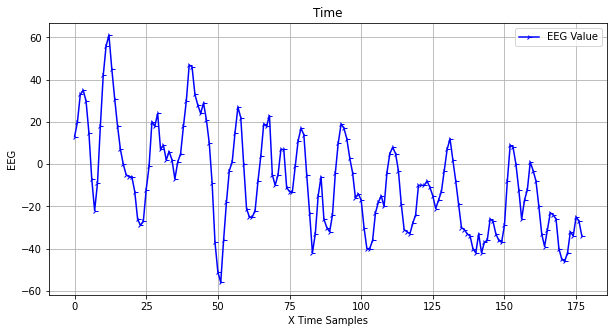

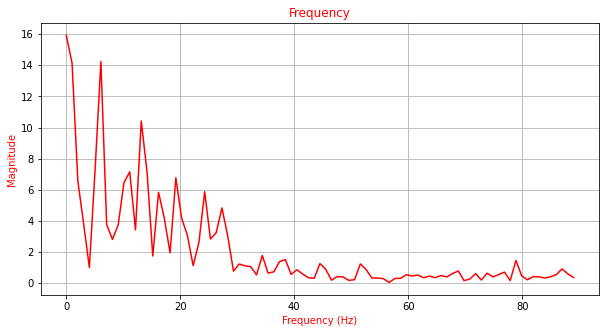

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88. -89. -88. -87. -86. -85. -84. -83. -82. -81.
 -80. -79. -78. -77. -76. -75. -74. -73. -72. -71. -70. -69. -68. -67.
 -66. -65. -64. -63. -62. -61. -60. -59. -58. -57. -56. -55. -54. -53.
 -52. -51. -50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39.
 -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25.
 -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11.
 -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
178
[-1.41700000e+03-0.00000000e+00j  1.97348795e+02-1.24128278e+03j
  1.20624233e+01-5.84154886

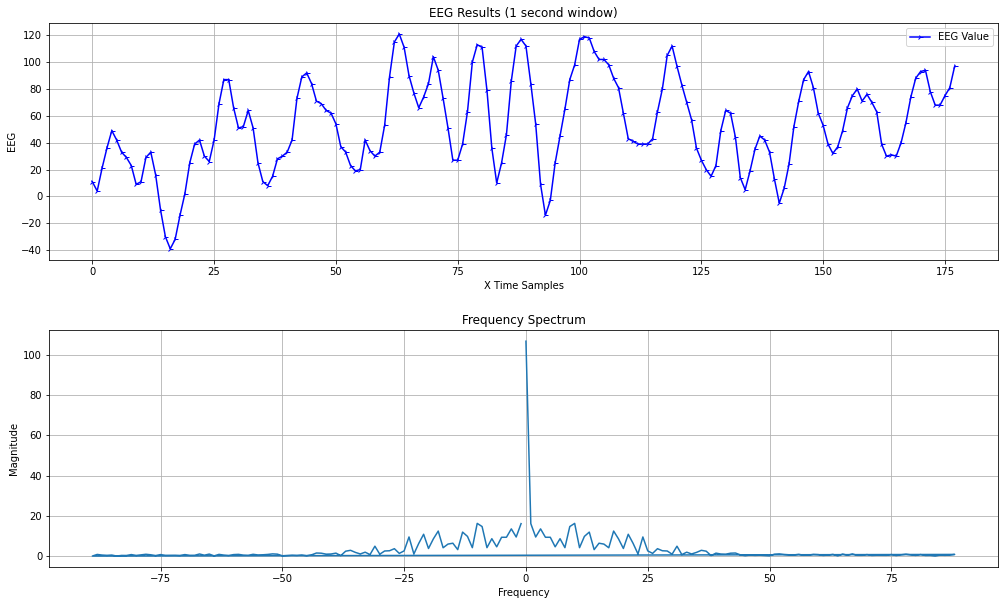

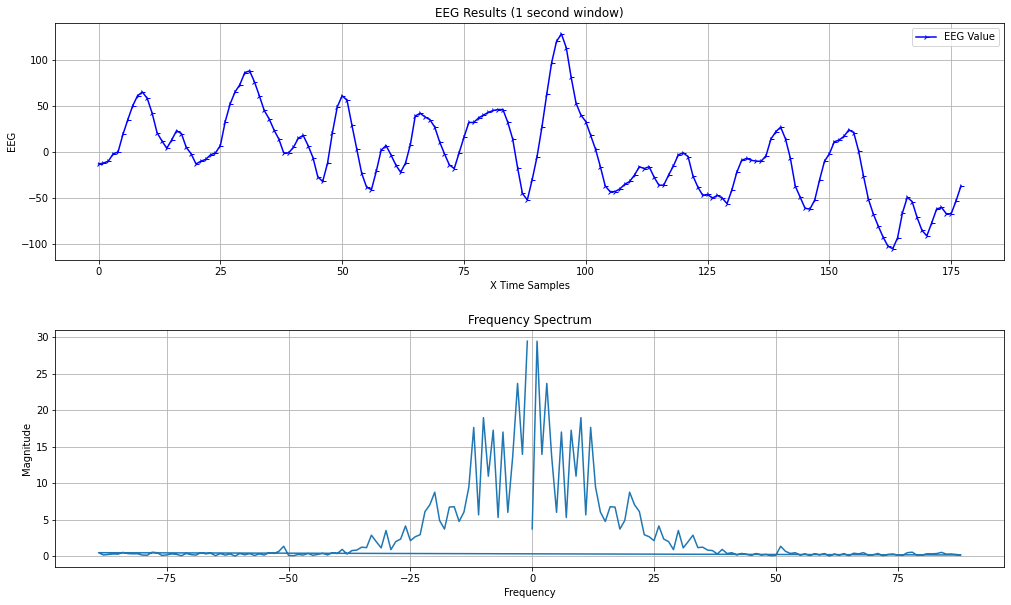

In [137]:
sample_Data = type5_DF.iloc[387]
plot_Time(sample_Data, epilepsyX_Axis, 'Time')
plot_Frequency(sample_Data, Frx, 'Frequency') 
print(Frx1)
epiFFT = fftpack.fft(sample_Data)
print(len(epiFFT))
print(epiFFT)
fft_plot_TF(type4_DF.iloc[132:134], epilepsyX_Axis, Frx1)

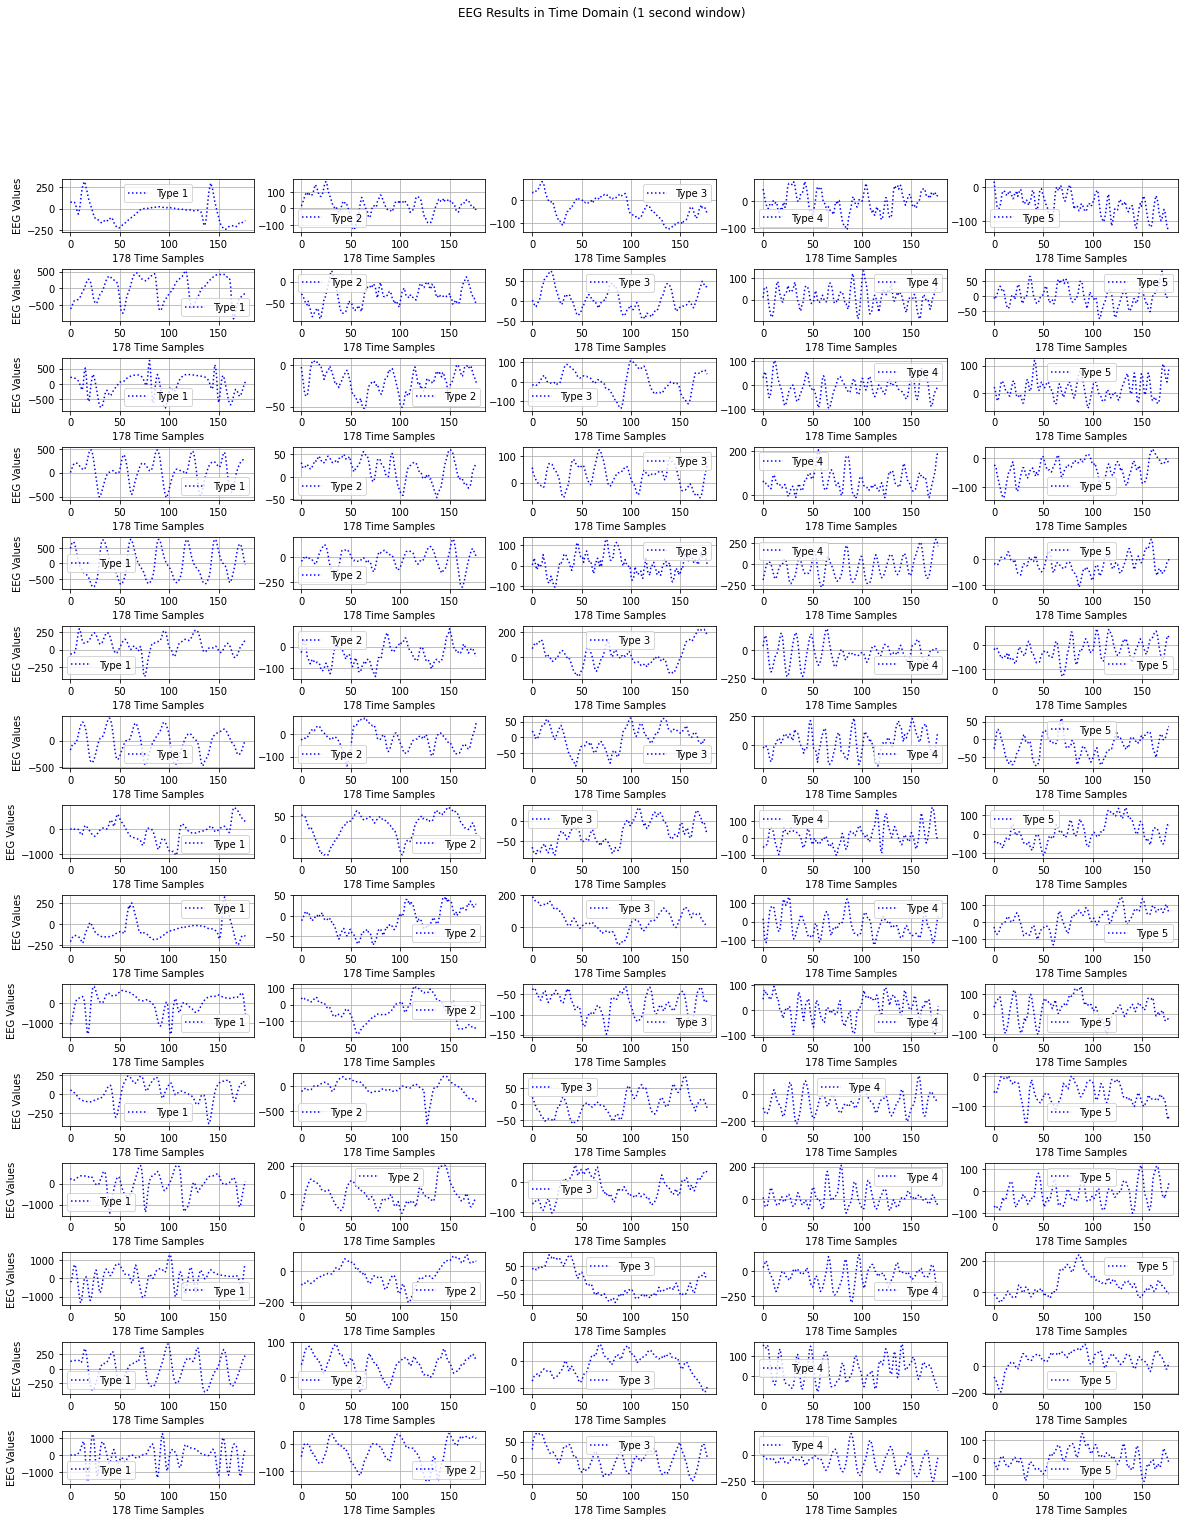

In [138]:
irt = list(range(100, 115))
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df5 = pd.DataFrame()

cutoff_frequency = 40  # Cutoff frequency to be used by the butter low pass filter

for idx in irt: 
    filteredData1 = butterLowPassFilter(type1_DF.iloc[idx], 4, cutoff_frequency, Fs)
    df1 = df1.append(pd.Series(filteredData1), ignore_index=True)
    
    filteredData2 = butterLowPassFilter(type2_DF.iloc[idx], 4, cutoff_frequency, Fs)
    df2 = df2.append(pd.Series(filteredData2), ignore_index=True)
    
    filteredData3 = butterLowPassFilter(type3_DF.iloc[idx], 4, cutoff_frequency, Fs)
    df3 = df3.append(pd.Series(filteredData3), ignore_index=True)
    
    filteredData4 = butterLowPassFilter(type4_DF.iloc[idx], 4, cutoff_frequency, Fs)
    df4 = df4.append(pd.Series(filteredData4), ignore_index=True)
    
    filteredData5 = butterLowPassFilter(type5_DF.iloc[idx], 4, cutoff_frequency, Fs)
    df5 = df5.append(pd.Series(filteredData5), ignore_index=True)
    
# Plot multiple time domain plots    
grid_plot(type1_DF.iloc[irt], type2_DF.iloc[irt], type3_DF.iloc[irt], type4_DF.iloc[irt], 
          type5_DF.iloc[irt], epilepsyX_Axis, Frx, False)

In [139]:
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177
0,72.017984,71.686422,74.122700,78.526740,76.051815,52.880452,5.665941,-44.913347,-62.843966,-24.687376,61.027545,162.084572,246.667416,297.882908,311.460318,290.162977,243.436638,186.039053,131.769960,87.485697,51.595252,17.518871,-19.522257,-57.842772,-91.265146,-114.653467,-127.107321,-131.849464,-134.706461,-141.253771,-152.942691,-165.260960,-170.500261,-163.901306,-148.747772,-135.352299,-132.833685,-140.177697,-146.036705,-139.366480,...,-49.525756,75.614561,187.776031,262.293393,288.777930,269.603639,217.491820,150.808532,86.010455,30.865220,-16.771409,-62.972424,-109.569842,-151.987091,-184.745718,-207.375457,-223.755774,-236.693845,-244.941207,-245.630264,-238.426066,-226.857276,-215.994579,-208.887345,-205.063223,-202.609750,-201.595595,-204.227979,-210.407490,-214.494276,-209.769113,-196.672434,-183.396328,-176.645641,-174.644362,-171.330226,-164.354832,-155.897335,-148.083878,-141.003598
1,-621.040331,-581.153836,-512.703351,-431.525505,-376.942287,-361.690668,-364.097785,-360.100447,-341.585793,-307.000766,-254.905408,-191.697379,-130.575646,-74.350088,-9.529742,73.474064,162.124648,232.585379,270.599499,269.680700,216.214789,96.807197,-74.386535,-250.326390,-382.842803,-452.648415,-463.873064,-424.329420,-346.129191,-256.006987,-184.447907,-139.831387,-101.657239,-43.108908,42.776128,140.024533,227.633066,295.134576,340.700731,361.201133,...,131.659940,179.426162,218.398319,244.082479,264.610270,290.139615,321.962481,353.204606,377.080106,391.942438,400.457474,406.584469,412.074935,414.241447,409.770491,402.973178,404.832925,416.118962,416.137814,385.244105,342.297791,332.253168,348.318018,288.073103,42.992937,-356.172363,-729.531831,-907.990168,-874.281499,-733.104690,-585.365395,-466.838268,-378.063804,-318.174871,-281.989723,-255.555585,-228.298740,-199.651065,-171.848585,-144.621095
2,214.122355,208.095915,202.457368,197.382297,190.102521,174.780203,150.060474,123.622918,96.571189,42.639484,-66.909553,-188.044978,-184.836849,36.784941,357.022324,484.084845,239.845007,-225.326738,-562.444423,-554.454990,-274.759131,49.341283,250.414922,293.958867,220.973522,79.408665,-99.855134,-296.581997,-488.511132,-648.068947,-751.395507,-786.301721,-749.440750,-644.300993,-491.269587,-335.669875,-233.059062,-216.421461,-272.519179,-349.388545,...,171.649289,142.023151,99.530663,8.933421,-127.262969,-202.754128,-69.013352,273.083936,578.553408,547.895961,138.105079,-364.616013,-608.678554,-483.533712,-155.372994,138.054756,270.088089,243.310833,116.761610,-52.281402,-228.878884,-397.435643,-545.530939,-651.688502,-691.723819,-654.675231,-550.551139,-408.401083,-271.701231,-187.895866,-186.558686,-257.486569,-351.200530,-408.151098,-394.848923,-317.976587,-209.494201,-100.979636,-7.678663,72.860979
3,2.980250,64.400102,120.382993,165.329687,194.577881,206.329623,202.685853,188.639801,169.521698,148.475352,125.884065,101.651540,78.494918,63.242346,65.674793,95.850571,159.033339,249.158551,347.366398,429.708991,476.957800,477.278890,424.929849,323.212004,186.912438,34.259946,-123.793220,-279.544104,-413.865229,-495.797301,-504.914263,-451.411368,-368.286452,-285.208367,-213.215783,-150.017785,-92.657186,-44.211621,-11.180296,4.647298,...,20.635494,80.066190,131.050371,169.928716,197.021304,215.446347,226.652483,229.406102,222.087703,204.076556,176.027029,142.620581,116.766991,117.777817,160.394423,242.759193,342.074798,417.595383,421.553544,324.588128,145.093729,-52.785163,-206.219792,-300.866838,-362.404565,-404.836677,-405.572122,-338.975450,-218.916553,-92.432216,3.941628,69.123634,121.302355,170.887902,214.612086,246.467314,264.404363,268.085026,257.797059,237.998126
4,486.999025,609.647151,690.842821,706.491967,651.049143,532.818674,374.461460,209.22

In [140]:
type1_DF.iloc[irt]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x139,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178
column_a,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
X11.V1.317,72,75,72,79,74,53,11,-48,-66,-21,57,167,248,289,318,293,235,193,129,88,50,20,-20,-59,-91,-114,-127,-133,-134,-141,-153,-166,-169,-165,-150,-133,-134,-140,-144,-144,...,-53,79,190,253,300,262,220,152,84,31,-16,-63,-109,-153,-185,-207,-223,-237,-246,-244,-240,-226,-216,-209,-205,-202,-204,-202,-210,-215,-211,-197,-182,-174,-180,-169,-164,-155,-150,-141
X8.V1.416,-621,-598,-513,-418,-377,-368,-369,-352,-343,-304,-263,-191,-122,-77,-14,72,166,237,268,259,228,93,-68,-257,-392,-435,-469,-429,-347,-252,-184,-140,-103,-45,45,140,228,297,335,363,...,131,180,220,244,263,289,325,352,377,391,402,407,410,414,411,406,403,412,413,394,351,325,325,292,94,-398,-723,-927,-852,-721,-606,-470,-369,-311,-295,-253,-224,-201,-173,-145
X19.V1.404,214,209,203,197,188,175,153,128,90,31,-63,-151,-204,5,355,518,266,-264,-581,-545,-246,40,232,309,217,78,-98,-299,-481,-657,-751,-780,-751,-648,-490,-335,-234,-214,-273,-350,...,176,142,88,3,-107,-175,-119,255,623,537,175,-417,-617,-459,-138,117,267,251,118,-57,-231,-390,-548,-654,-692,-652,-551,-409,-274,-186,-185,-258,-351,-411,-394,-316,-210,-102,-7,73
X23.V1.534,3,65,119,167,193,208,201,190,169,148,126,103,77,63,67,96,158,248,349,431,476,474,427,329,179,36,-123,-280,-408,-503,-507,-445,-369,-288,-212,-149,-95,-42,-14,9,...,18,82,132,169,197,215,227,230,222,203,176,144,117,117,158,246,345,409,424,329,148,-58,-211,-301,-350,-409,-411,-341,-215,-89,3,65,121,175,213,247,262,270,258,238
X10.V1.716,487,620,686,701,656,534,374,205,71,-45,-119,-186,-235,-293,-323,-363,-367,-393,-430,-514,-601,-695,-755,-774,-763,-693,-616,-506,-290,7,357,621,748,759,741,669,569,452,312,189,...,-622,-547,-473,-334,-85,220,520,710,771,774,682,531,380,248,140,69,12,-28,-49,-109,-208,-360,-517,-617,-621,-512,-398,-259,-133,55,266,447,562,624,617,550,402,232,66,-53
X18.V1.634,-68,-62,-63,-53,-47,-14,57,162,257,304,265,197,131,99,95,94,100,109,119,137,160,197,220,240,245,236,214,178,138,99,80,81,99,131,169,207,231,248,243,222,...,-11,9,21,24,23,21,24,38,49,50,37,12,-16,-38,-43,-35,-18,13,43,69,84,91,85,64,30,-12,-59,-93,-114,-115,-107,-73,-36,9,38,60,75,100,121,123
X12.V1.874,-179,-120,-81,-57,-55,-57,-30,26,118,196,264,315,345,340,301,238,154,24,-127,-272,-373,-414,-413,-391,-349,-288,-207,-126,-51,5,40,52,61,89,136,206,273,338,388,420,...,-324,-290,-228,-149,-61,11,61,88,103,119,136,148,155,164,173,188,202,211,212,197,169,129,90,55,9,-29,-54,-71,-103,-160,-216,-253,-269,-260,-238,-204,-150,-88,-35,8
X18.V1.617,-6,37,53,35,11,-1,10,12,2,-59,-161,-227,-192,-46,96,164,144,89,26,-29,-92,-152,-212,-249,-275,-268,-239,-191,-136,-76,-22,17,45,58,52,40,14,24,82,207,...,4,26,64,106,140,127,68,-10,-71,-95,-82,-48,-2,41,61,90,113,133,126,88,32,-74,-107,-129,118,422,729,882,891,860,830,782,716,633,552,485,440,399,358,317
X20.V1.317,-210,-181,-160,-143,-135,-136,-142,-148,-153,-159,-173,-200,-226,-215,-165,-114,-84,-60,-34,2,19,1,-25,-47,-74,-95,-104,-115,-128,-134,-142,-146,-154,-152,-152,-152,-155,-153,-151,-151,...,-44,-50,-56,-56,-57,-57,-57,-63,-71,-78,-88,-113,-158,-177,-121,-9,180,288,321,271,208,169,143,87,36,-1,-47,-90,-138,-187,-230,-247,-243,-218,-183,-152,-137,-134,-138,-145


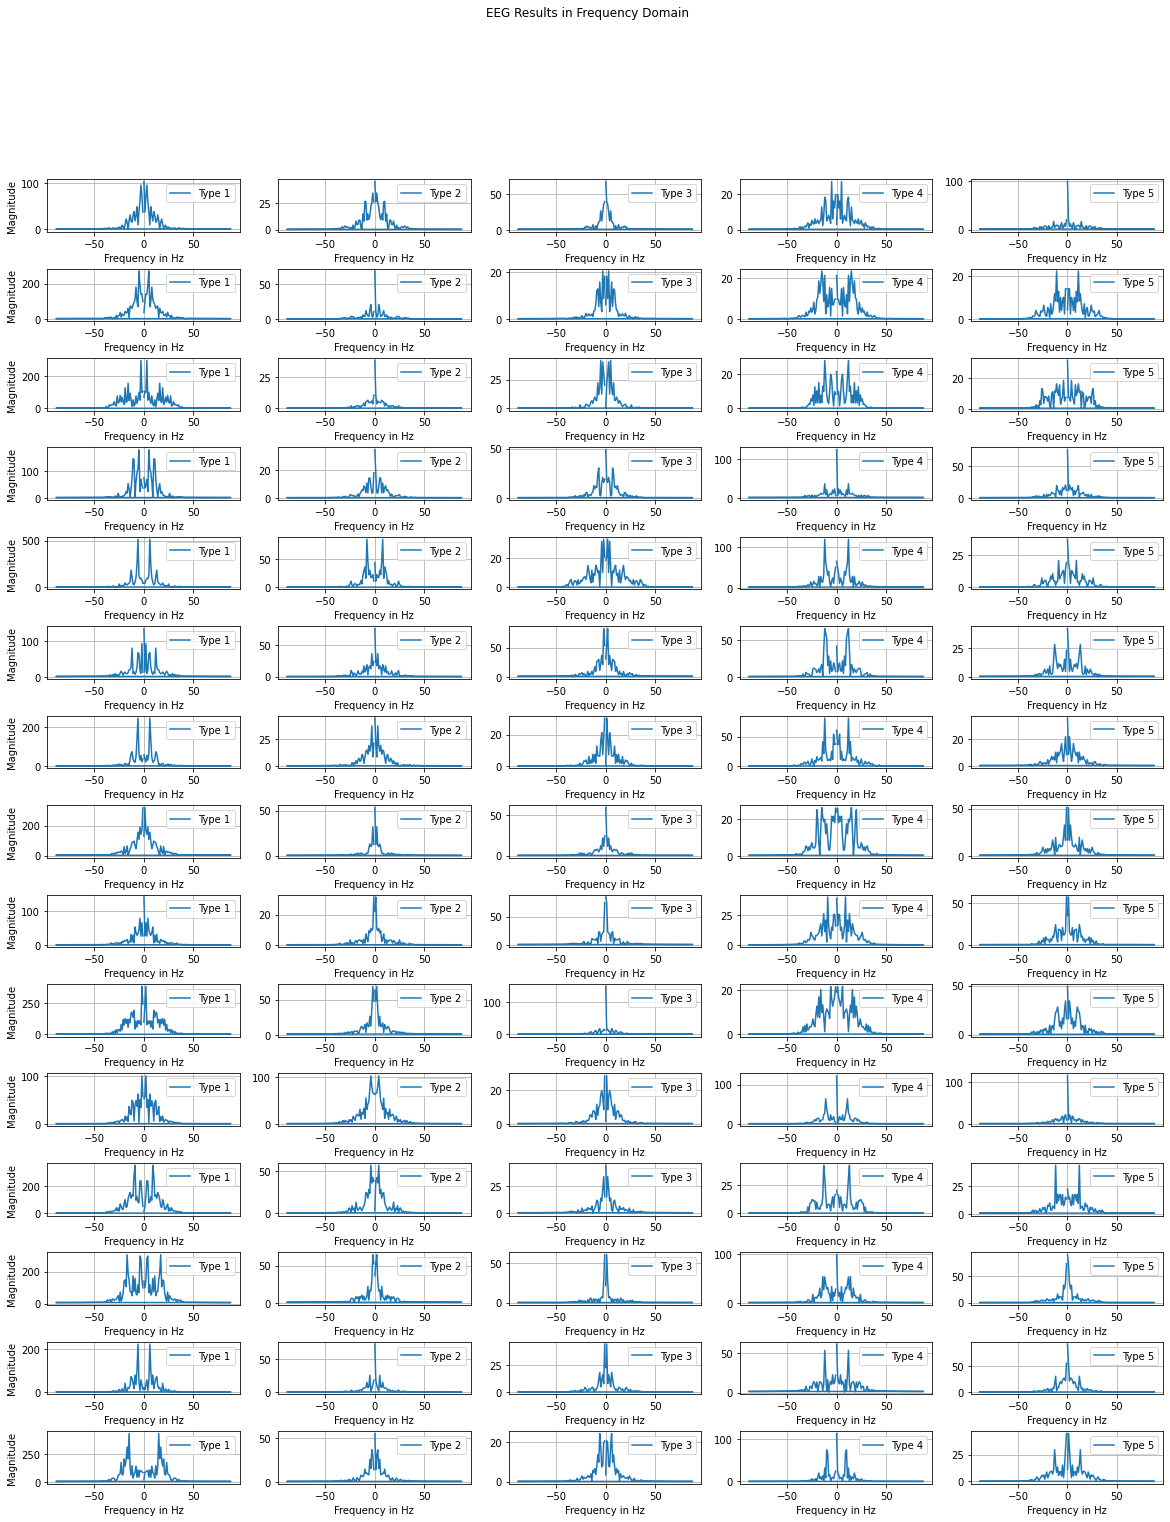

In [141]:
# Plot multiple Frequency domain plots    
grid_plot(df1, df2, df3, df4, df5, epilepsyX_Axis, Frx1, True)

In [142]:
# These loading scripts are for one time loading to show the final result sets and it takes some time to load.
# Uncomment only when ready to load

MyDF = loadRMSValues(MyDF)
MyDF = loadStatisticalValues(MyDF)
MyDF = loadZeroCrossings(MyDF)
MyDF = loadTimeDomainPeaks(MyDF)
MyDF = loadFrequencyDomainPeaks(MyDF)
MyDF = loadPSD(MyDF)
MyDF.to_csv("EEG_FFT.csv")
# print(MyDF)

In [147]:
MyDF

,YLabel,Max,Min,Mean,SD,Variance,RMS,ZeroXings,TPeaks,TMax1,TMax2,TMax3,FPeaks,FMax1,FMax2,FMax3,PSD,RelativeAlpha,RelativeBeta,RelativeTheta,RelativeDelta
0,4,229,-281,-16.9101,95.711,9160.59,97.1933,23,16,116.936,141.801,209.508,14,24.4136,51.3937,73.5705,11593.1,0.09,0.64,0.01,0.23
1,1,513,-1716,28.1124,471.836,222629,472.673,8,13,435.33,504.758,463.558,15,143.647,193.992,350.685,265205,0.08,0.12,0.22,0.56
2,5,80,-126,-44.0449,44.1864,1952.44,62.389,12,14,33.138,66.837,53.4413,15,18.2842,20.9651,26.9656,1504.05,0.2,0.33,0.22,0.19
3,5,-22,-105,-68.9101,15.9237,253.565,70.726,0,20,-34.4378,-31.304,-31.9052,10,5.91763,7.07505,7.96749,253.09,0.19,0.36,0.14,0.28
4,5,78,-103,-6.65169,38.693,1497.15,39.2606,27,21,51.7829,52.5556,64.1552,15,12.3261,12.7984,29.1406,1004.99,0.11,0.35,0.13,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,2,73,-79,5.1573,38.2685,1464.48,38.6145,4,7,63.9961,65.0495,69.749,10,16.2743,19.2522,40.3315,1311.51,0.07,0.01,0.37,0.29
11496,1,471,-388,5.67416,163.079,26594.6,163.177,10,9,226.26,456.946,233.939,18,71.5318,85.7018,134.32,18639.7,0.2,0.14,0.51,0.09
11497,5,121,-90,6.75281,44.1649,1950.53,44.6781,25,24,79.9524,104.571,97.0364,12,12.7236,19.2434,37.8124,1616.54,0.02,0.54,0.05,0.29
11498,3,148,-157,-38.8427,63.4283,4023.16,74.3768,7,13,23.5991,26.4818,140.017,13,17.9424,38.146,54.0487,2144.02,0.41,0.09,0.17,0.28


In [198]:
# https://piptowardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
y = MyDF["YLabel"]
X = MyDF.drop(columns=["YLabel"])

In [204]:
# Type 1 is very easily classified so we remove them
MyDF_Corr = MyDF[MyDF['YLabel'] >= 2].astype('float64').corr()
MyDF_Corr

,YLabel,Max,Min,Mean,SD,Variance,RMS,ZeroXings,TPeaks,TMax1,TMax2,TMax3,FPeaks,FMax1,FMax2,FMax3,PSD,RelativeAlpha,RelativeBeta,RelativeTheta,RelativeDelta
YLabel,1.000000,-0.123333,0.107621,-0.013701,-0.179232,-0.139845,-0.165244,0.502190,0.573889,0.030202,-0.063954,-0.131014,0.170446,-0.014104,-0.106088,-0.244084,-0.113327,0.286969,0.613210,-0.251147,-0.486005
Max,-0.123333,1.000000,-0.379182,0.305380,0.879314,0.850099,0.792227,0.044602,-0.156288,0.382531,0.603459,0.958353,0.205204,0.561578,0.592651,0.779857,0.678825,0.043669,-0.033593,-0.159096,0.020632
Min,0.107621,-0.379182,1.000000,0.406861,-0.723302,-0.476061,-0.730592,0.000811,0.247978,-0.229736,-0.336282,-0.352747,-0.298300,-0.636333,-0.635332,-0.633293,-0.407035,-0.146322,-0.011042,0.187338,0.008296
Mean,-0.013701,0.305380,0.406861,1.000000,0.038400,0.082663,-0.113561,0.183445,0.111068,0.604043,0.447788,0.321511,0.056460,0.036687,0.019963,0.051818,0.096039,-0.070299,-0.041809,0.014621,0.060366
SD,-0.179232,0.879314,-0.723302,0.038400,1.000000,0.860520,0.935915,-0.011282,-0.283470,0.413026,0.617993,0.845981,0.281431,0.692172,0.736165,0.906116,0.712104,0.085107,-0.082467,-0.212333,0.065035
Variance,-0.139845,0.850099,-0.476061,0.082663,0.860520,1.000000,0.823547,-0.078582,-0.200505,0.143445,0.442552,0.819188,0.104522,0.476786,0.540944,0.782723,0.834670,-0.009023,-0.083638,-0.089511,0.070078
RMS,-0.165244,0.792227,-0.730592,-0.113561,0.935915,0.823547,1.000000,-0.179957,-0.262380,0.274458,0.504195,0.755575,0.236999,0.617507,0.661921,0.821463,0.679942,0.081302,-0.052693,-0.195792,0.039984
ZeroXings,0.502190,0.044602,0.000811,0.183445,-0.011282,-0.078582,-0.179957,1.000000,0.459151,0.318894,0.170531,0.034829,0.289843,0.216033,0.115941,-0.100278,-0.056650,0.350133,0.584597,-0.193834,-0.497787
TPeaks,0.573889,-0.156288,0.247978,0.111068,-0.283470,-0.200505,-0.262380,0.459151,1.000000,0.019544,-0.095540,-0.157101,0.195348,-0.106459,-0.260334,-0.324276,-0.170996,-0.015504,0.550682,-0.199402,-0.280538
TMax1,0.030202,0.382531,-0.229736,0.604043,0.413026,0.143445,0.274458,0.318894,0.019544,1.000000,0.702554,0.386849,0.350008,0.469400,0.433815,0.365620,0.166673,0.212995,0.080921,-0.212099,-0.087884


Text(0.5, 0.98, 'Engineering Parameters Correlation Heatmap')

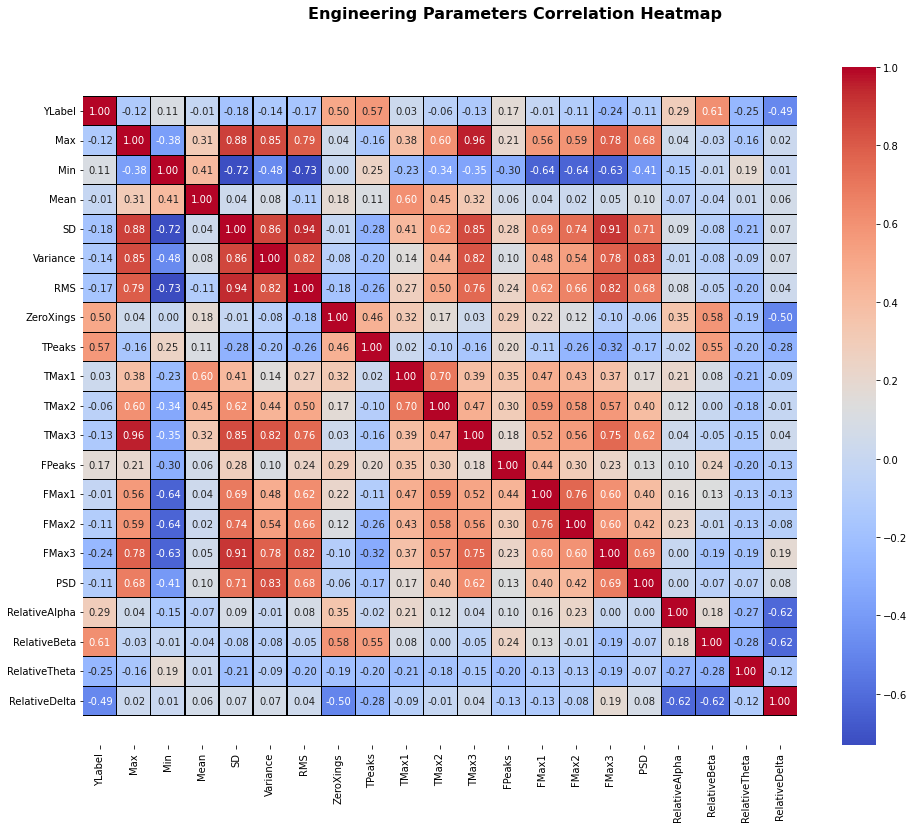

In [206]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 12))

hm = sns.heatmap(MyDF_Corr, 
                 ax=ax,           
                 cmap="coolwarm",
                 #square=True,    
                 annot=True, 
                 fmt='.2f', 
                 annot_kws={"size": 10},
                 linecolor='black',
                 linewidths=.05)

b,t = hm.get_ylim()
b = b + 1.0
t = t - 1.0
hm.set_ylim(b ,t)

fig.subplots_adjust(top=0.91)
fig.suptitle('Engineering Parameters Correlation Heatmap', 
              fontsize=16, 
              fontweight='bold')

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 12))
hm = sns.heatmap(MyDF_Corr, 
                 ax=ax,           
                 cmap="coolwarm",
                 #square=True,    
                 annot=True, 
                 fmt='.2f', 
                 annot_kws={"size": 10},
                 linecolor='black',
                 linewidths=.05)
b,t = hm.get_ylim()
b = b + 1.0
t = t - 1.0
hm.set_ylim(b ,t)

fig.subplots_adjust(top=0.91)
fig.suptitle('Engineering Parameters Correlation Heatmap', 
              fontsize=16, 
              fontweight='bold')

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso

pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.752, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.766, total=   0.1s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................... model__alpha=0.1, score=-0.716, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.732, total=   0.0s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.763, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.868, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.871, total=   0.0s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.836, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.864, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:   26.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprec...
       2.7, 2.8, 2.9, 3. , 3.1,

In [154]:
search.best_params_

{'model__alpha': 0.1}

In [155]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [166]:
importance = np.abs(coefficients)
importance

array([0.16614428, 0.23648889, 0.        , 0.        , 0.        ,
       0.        , 0.04578298, 0.42771619, 0.0028025 , 0.15435676,
       0.        , 0.        , 0.08084747, 0.        , 0.        ,
       0.        , 0.17759965, 0.18563782, 0.10504484, 0.        ])

In [167]:
features = X.columns
len(features)

20

In [165]:
np.array(features)[importance > 0]

array(['Max', 'Min', 'Mean', 'SD', 'Variance', 'RMS', 'ZeroXings',
       'TPeaks', 'TMax1', 'TMax2', 'TMax3', 'FPeaks', 'FMax1', 'FMax2',
       'FMax3', 'PSD', 'RelativeAlpha', 'RelativeBeta', 'RelativeTheta',
       'RelativeDelta'], dtype=object)

In [168]:
X_lasso = X[np.array(features)[importance > 0]]

In [169]:
X_lasso

,Max,Min,ZeroXings,TPeaks,TMax1,TMax2,FMax1,RelativeAlpha,RelativeBeta,RelativeTheta
0,229,-281,23,16,116.936,141.801,24.4136,0.09,0.64,0.01
1,513,-1716,8,13,435.33,504.758,143.647,0.08,0.12,0.22
2,80,-126,12,14,33.138,66.837,18.2842,0.2,0.33,0.22
3,-22,-105,0,20,-34.4378,-31.304,5.91763,0.19,0.36,0.14
4,78,-103,27,21,51.7829,52.5556,12.3261,0.11,0.35,0.13
...,...,...,...,...,...,...,...,...,...,...
11495,73,-79,4,7,63.9961,65.0495,16.2743,0.07,0.01,0.37
11496,471,-388,10,9,226.26,456.946,71.5318,0.2,0.14,0.51
11497,121,-90,25,24,79.9524,104.571,12.7236,0.02,0.54,0.05
11498,148,-157,7,13,23.5991,26.4818,17.9424,0.41,0.09,0.17


In [185]:
from sklearn.preprocessing import normalize
X_lasso_normal = normalize(X_lasso, norm='l2',axis=0)
y = y.astype('int')

In [186]:
X_train_lasso, X_test_lasso, y_train, y_test = train_test_split(X_lasso_normal, y, test_size=0.7, random_state=42)

In [188]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
param_grid = {'degree': range(2,8),  'C': np.logspace(-2,5,20)}
param_grid = { 'C': np.logspace(-2,4,4)}
SvmGS = GridSearchCV(estimator, param_grid)
SvmGS.fit(X_lasso_normal, y)
best_SVM = SvmGS.best_estimator_
best_SVM

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [189]:
best_SVM.fit(X_train_lasso, y_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [190]:
def get_metrics(clf, SS_X, y ):
    y_pred = clf.predict(SS_X)
    y_proba = clf.predict_proba(SS_X)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average = 'macro')
    precision = precision_score(y, y_pred, average = 'macro')
    f1 = f1_score(y, y_pred, average = 'macro')

    onehot_proba = []
    onehot_y = []
    for i in range(5):
        temp_proba = y_proba[:,i]
        temp_y = np.where( y == i+1, 1, 0 )
        onehot_proba.append(temp_proba)
        onehot_y.append(temp_y)

    ravel_onehot_proba = np.array(onehot_proba).ravel()
    ravel_onehot_y = np.array(onehot_y).ravel()
    fpr,tpr,threshold = roc_curve(ravel_onehot_y, ravel_onehot_proba) 
    roc_auc = auc(fpr,tpr)
    return accuracy, recall, precision, f1, roc_auc

In [191]:
get_metrics(best_SVM, X_test_lasso, y_test)

(0.7142857142857143,
 0.715337231549492,
 0.7151857134238109,
 0.7142060256935997,
 0.9448568033640677)

In [192]:
estimator = MLPClassifier(max_iter=1000)
param_grid = {'hidden_layer_sizes': [64,128,256,512]}
MLPGS = GridSearchCV(estimator, param_grid)
MLPGS.fit(X_lasso_normal, y)
best_MLP = MLPGS.best_estimator_
best_MLP

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=512, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [193]:
best_MLP.fit(X_train_lasso, y_train)
get_metrics(best_MLP, X_test_lasso, y_test)

(0.6860869565217391,
 0.6875069198042334,
 0.6863056395086378,
 0.6864293864835858,
 0.9373510589869218)